In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 1.0 Access to data files

In [2]:
current_dir = os.getcwd()
data_dir = current_dir + "/data"

municipalities_data =  data_dir + "/municipalities.parquet"

## 1.1 Study Area 

- First, we read the municipalities data (contaning the spatial shapes of the municipalities in France).
- The raw data format can be found at  https://geoservices.ign.fr/contoursiris (2021 version).
- In this study, we take advantage of the cleanded data format, which can be found from here: https://drive.google.com/drive/folders/1ut28N-SBsaDlWXudfgfQjgOxZfCnEd8C.

In [3]:
# geopandas
df_municipalities = gpd.read_parquet(municipalities_data)
df_municipalities.head()

,municipality_id,geometry,iris_id,department_id
0,01001,"POLYGON ((851129.600 6563369.200, 851107.500 6...",010010000,01
1,01002,"POLYGON ((889113.200 6549307.800, 889111.600 6...",010020000,01
2,01004,"POLYGON ((882936.400 6541364.300, 882932.900 6...",010040102,01
3,01005,"POLYGON ((846758.000 6544007.000, 846755.000 6...",010050000,01
4,01006,"POLYGON ((900682.500 6518954.000, 900466.600 6...",010060000,01


#### a. We choose the city Strasbourg, which is located at the east of France. Strasbourg has municipalicty ID "67482", and its department are Bas-Rhin with the ID "67"

<Axes: >

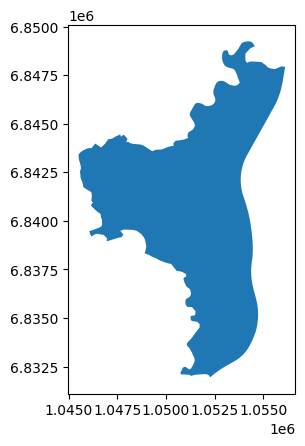

In [26]:
Strasbourg_id = "67482"
Strasbourg_df = df_municipalities[df_municipalities['municipality_id'].str[:5] == Strasbourg_id]
Strasbourg_df.plot()

#### b. We visualize the Bas-Rhin department on the map with geopandas, and highlight the chosen municipality (Strasbourg) as blue color, and its neighbours as red color

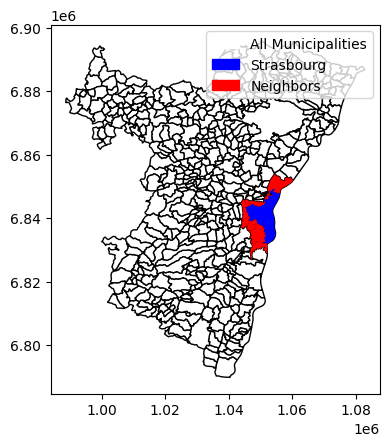

In [31]:
# all muniticpalties in the department 67
department_id = df_municipalities[df_municipalities['department_id'].str[:2] == "67"]
department_id.plot(color='white', edgecolor='black', label='All Municipalities')

# highlight Strasbourg
df_municipalities[df_municipalities['municipality_id'] == Strasbourg_id].plot(color='blue', ax=plt.gca(), label='Strasbourg')

# neighboors of Strasbourg
neighboors = ['67131', '67218', '67365', '67267', '67118', '67343', '67296', '67447', '67519']
department_id[department_id['municipality_id'].isin(neighboors)].plot(color='red', ax=plt.gca(), label='Neighbours')

# Create legend handles
handles = [
    mpatches.Patch(color='white', label='All Municipalities'),
    mpatches.Patch(color='blue', label='Strasbourg'),
    mpatches.Patch(color='red', label='Neighbors')
]

# Add legend with handles
plt.legend(handles=handles)
plt.show()

- We save the studied area as a gpkg file for visualization in QGIS software

In [6]:
department_id.to_file("studied_area.gpkg")

## 1.2 Territorial analysis I

We read the census data (which describes characteristics of each person in certain area in France)

- The data can be found in here: https://www.insee.fr/fr/statistiques/6544333#consulter

Variables: 

- IRIS: identifier for the location of the observation in France, load it as `str`
- IPONDI: a weight of each observation, load it as `float`
- AGED: the age of each observation, load it as `int`
- CS1: Socioprofessional category (Catégorie socioprofessionnelle en 8 postes) as `int`


In [7]:
columns = {
    "IRIS": str,
    "IPONDI": float,
    "AGED": int,
    "CS1": int
}

census_data = data_dir + "/FD_INDCVI_2019.csv"
# data about characteristics of each person in certain area
df_census = pd.read_csv(census_data, sep = ";", dtype = columns, usecols = columns.keys())
df_census.head()

,AGED,CS1,IPONDI,IRIS
0,68,7,3.324481,010040101
1,33,6,2.957422,010040202
2,1,8,2.957422,010040202
3,30,6,2.957422,010040202
4,72,7,5.046771,ZZZZZZZZZ


- Next, we rename the columns of census data for better readability

In [8]:
df_census = df_census.rename(columns = {
    "IRIS": "iris_id",
    "IPONDI": "weight",
    "AGED": "age",
    "CS1": "csp"
})

df_census.head()

,age,csp,weight,iris_id
0,68,7,3.324481,010040101
1,33,6,2.957422,010040202
2,1,8,2.957422,010040202
3,30,6,2.957422,010040202
4,72,7,5.046771,ZZZZZZZZZ


#### a. Provide a list of municipality identifiers for all the municipalities included in the study area.

- We utilize the municipalities data to provide a list of ID for all the municipalities in the study area (Bas-Rhin department).
- We can see that there are 514 municipalities in the study area.

In [9]:
df_municipalities[df_municipalities['department_id'].str[:2] == "67"]

,municipality_id,geometry,iris_id,department_id
26127,67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67
26128,67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67
26129,67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67
26130,67004,"POLYGON ((1019659.800 6849380.600, 1019699.600...",670040000,67
26131,67005,"POLYGON ((1038941.700 6865681.100, 1038947.600...",670050000,67
...,...,...,...,...
26636,67555,"POLYGON ((1026320.400 6850784.300, 1026353.000...",675550000,67
26637,67556,"POLYGON ((1030467.400 6852288.700, 1030439.400...",675560000,67
26638,67557,"POLYGON ((1032259.800 6821503.800, 1032336.500...",675570000,67
26639,67558,"POLYGON ((1033867.200 6880068.100, 1033889.300...",675580000,67


#### b.  In a table, provide the number of samples (data points) in the census data for each municipality along with the weighted population count (including zero). 

- In the census data, the `weight` represents the number of samples associated with each municipality. Taking the `sum` of these weights will get us the total population represented by the data for each municipality, taking into account the sample sizes.

- To see how many samples contribution to the population count, we count the `weight`and get the the actual number of data points used for each municipality.

In [10]:
weighted_population_count = df_census.groupby('iris_id')['weight'].sum()
number_of_samples = df_census.groupby('iris_id')['weight'].count()
table = pd.DataFrame({'iris_id': weighted_population_count.index,
                   'weighted_population_count': weighted_population_count.values,
                   'number_of_samples': number_of_samples.values})

table

,iris_id,weighted_population_count,number_of_samples
0,010040101,1.896820e+03,802
1,010040102,3.597839e+03,1665
2,010040201,4.118478e+03,1553
3,010040202,4.532863e+03,1803
4,010330102,2.918102e+03,1141
...,...,...,...
15907,974240102,1.677028e+03,330
15908,974240103,7.254382e+02,143
15909,974240104,1.029640e+03,204
15910,974240105,3.841862e+02,77


#### c. Plot the age distribution of the study area and at least three municipalities in the study area.

- Recall that Strasbourg has the iris_id: "674821202", and its three neighbours are : "672180102", "673650102", "674470401"
- We perform the `group by` for the `age`column , and take the `sum` for the `weight` column to get the number of people at certain age in each municipality.

In [22]:
city_Strasbourg= df_census[df_census['iris_id'] == "674821202"]
city_672180102 = df_census[df_census['iris_id'] == "672180102"]
city_673650102 = df_census[df_census['iris_id'] == "673650102"]
city_674470401 = df_census[df_census['iris_id'] == "674470401"]

# reset_index() to add two new columns, `age` and `weight`
age_Strasbourg= city_Strasbourg.groupby('age')["weight"].sum().reset_index()
age_672180102 = city_672180102.groupby('age')["weight"].sum().reset_index()
age_673650102 = city_673650102.groupby('age')["weight"].sum().reset_index()
age_674470401 = city_674470401.groupby('age')["weight"].sum().reset_index()

- We plot the age distribution of Strasbourg and its neighbours.

In [23]:
# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Strasbourg", "672180102 city", "673650102 city", "674470401 city"))

# Add the bar charts to the subplots
fig.add_trace(go.Bar(x=age_Strasbourg["age"], y=age_Strasbourg["weight"]), row=1, col=1)
fig.add_trace(go.Bar(x=age_672180102["age"], y=age_672180102["weight"]), row=1, col=2)
fig.add_trace(go.Bar(x=age_673650102["age"], y=age_673650102["weight"]), row=2, col=1)
fig.add_trace(go.Bar(x=age_674470401["age"], y=age_674470401["weight"]), row=2, col=2)

# Update the layout
fig.update_layout(height=600, width=800, title_text="Population Distribution by Age")

# Show the plot
fig.show()

Analysis of the population distribution by age of the plotted areas:

- Strasbourg (represented in blue) has the largest population of middle-aged people (between 20 and 40 years old).
- City 67447041 (represented in purple) is the youngest cities with most people under 20 years old.
- Cities 673650102 and 672180102 (with green and orange colours respectively) have some similarities in the age distributions, with a higher concentration of residents between 40 and 60 years old. This makes them the oldest areas among those plotted.

#### d. Plot the distribution of social-professional categories of the study area and of at least three municipalities in the study area. 

In [24]:
# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Strasbourg", "672180102 city", "673650102 city", "674470401 city"))

# Add the bar charts to the subplots
fig.add_trace(go.Bar(x=city_Strasbourg["csp"], y=city_Strasbourg["weight"]), row=1, col=1)
fig.add_trace(go.Bar(x=city_672180102["csp"], y=city_672180102["weight"]), row=1, col=2)
fig.add_trace(go.Bar(x=city_673650102["csp"], y=city_673650102["weight"]), row=2, col=1)
fig.add_trace(go.Bar(x=city_674470401["csp"], y=city_674470401["weight"]), row=2, col=2)

# Update the layout
fig.update_layout(height=600, width=800, title_text="Population Distribution by Social-Professional Categories ")

# Show the plot
fig.show()

Analysis of the population distribution by social-professional categories:
- `Most residents inactive`: Across all analyzed areas, the largest group belongs to social-professional category 8, indicating those with no professional activity. City 674470401 has the highest number of inactive individuals.
- `Strasbourg and 673650102 city`: These two cities show similar distributions. A significant portion of their populations fall into categories 3, 4, and 5, which typically encompass skilled workers and professionals.
- `Low representation in 674470401 city`: Interestingly, city 674470401 has a very small population in categories 2 and 3.


## 1.3 Territorial analysis II

- First, we read the population data, which indicates the characteristics of the population by sex, age, socio-professional category and category nationality.
- The data can be found in: https://www.insee.fr/fr/statistiques/6543200, with the title: "Population en 2019 - IRIS - France hors Mayotte".

In [33]:
population_data = data_dir + "/base-ic-evol-struct-pop-2019.CSV"

# characteristics of the population by sex, age, socio-professional category and category nationality.
df_population = pd.read_csv(population_data, sep = ";", dtype = {
    "COM": "str"
}, usecols = ["COM", "P19_POP"] + ["C19_POP15P_CS{}".format(k) for k in range(1,9)])

for k in range(1, 9):
    df_population["csp_{}".format(k)] = df_population["C19_POP15P_CS{}".format(k)]
    
df_population = df_population[["COM", "P19_POP"] + ["csp_{}".format(k) for k in range(1,9)]]
df_population.columns = ["municipality_id", "population"] + ["csp_{}".format(k) for k in range(1,9)]
df_population = df_population.groupby("municipality_id").sum().reset_index()

In [34]:
# example in municipality "01001", population = 779, including 15 people from social professional category 1
df_population.head()

,municipality_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
0,01001,779.0,15.565978,19.822632,76.142088,98.357964,100.516361,126.843164,152.541469,29.616393
1,01002,256.0,0.000000,21.265503,15.927908,26.460181,42.135589,10.596822,67.296631,21.726261
2,01004,14134.0,2.762881,327.166403,784.225660,1890.243930,1891.133347,2001.750487,2763.422684,1848.127141
3,01005,1751.0,4.913019,112.999439,112.999439,221.085859,294.781145,186.694725,338.998316,117.912458
4,01006,112.0,0.000000,0.000000,5.090909,25.454545,15.272727,15.272727,25.454545,5.090909


In [45]:
## all the cities in the studied area with department 67
df_studied_areas_population = pd.merge(df_municipalities[df_municipalities["department_id"].str[:2] == "67"], 
                                       df_population)

df_studied_areas_population.head(3)

,municipality_id,geometry,iris_id,department_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
0,67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67,2338.0,5.646152,54.866827,252.144924,245.426134,217.790997,198.858441,779.312893,218.214182
1,67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67,390.0,9.848485,4.924242,4.924242,49.242424,34.469697,73.863636,113.257576,29.545455
2,67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67,441.0,5.140441,14.723528,24.379381,53.270841,63.756696,58.812224,122.822350,32.632977


#### a. Create a bar plot indicating the number of inhabitants in each municipality of the study area. Also, provide this information on a map.

In [46]:
px.bar(df_studied_areas_population, x='municipality_id', y='population')

<Axes: >

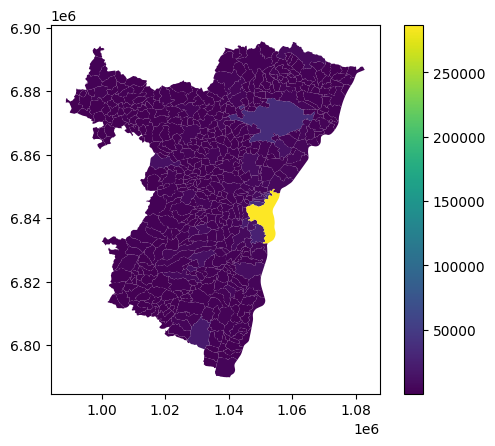

In [47]:
df_studied_areas_population.plot("population", legend=True)

- Next, we read the employment data, which indicates the number of employees in the private sector, by municipality.
- The raw data format can be found from here: https://open.urssaf.fr/explore/dataset/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/information/

In [48]:
# Employment data per municipality 

data_employment = data_dir + "/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv"
df_employment = pd.read_csv(data_employment, sep = ";", 
    usecols = ["Code commune", "Effectifs salariés 2019"], dtype = { "Code commune": str })

df_employment = df_employment.rename(columns = {
    "Code commune": "municipality_id",
    "Effectifs salariés 2019": "employment"
})

df_employment = df_employment.groupby("municipality_id").sum().reset_index()
df_employment.head()

,municipality_id,employment
0,01001,29.0
1,01002,2.0
2,01004,4859.0
3,01005,115.0
4,01007,302.0


#### b. Make use of the employment data to create a bar plot indicating the number of employees in each municipality of the study area. Also, provide this information on a map.

In [49]:
df_studied_area_employee = df_employment[df_employment['municipality_id'].str[:2] == "67"]

In [50]:
px.bar(df_studied_area_employee, x='municipality_id', y='employment')

<Axes: >

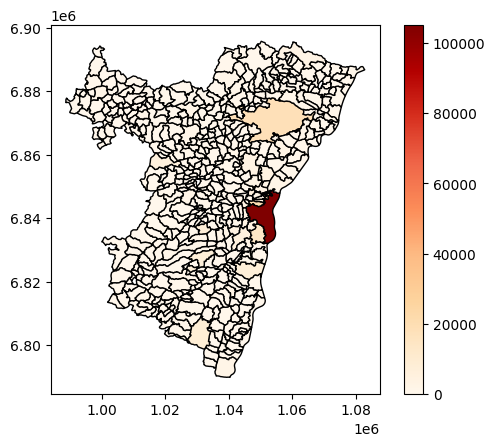

In [51]:
pd.merge(df_municipalities[df_municipalities["department_id"].str[:2] == "67"], df_studied_area_employee).plot("employment", 
                                                                                                               legend=True,
                                                                                                               cmap='OrRd',
                                                                                                               edgecolor='black')

#### c. Report the total number of inhabitants of the study area and the total number of employees in the study area.


- We caculate the total population and the number of employees from private sectors in the study area.

In [52]:
df_studied_areas_population['population'].sum(), df_studied_area_employee['employment'].sum()

(1140057.0, 353450.0)

- In the whole study area (Bas-Rhin department), the region has around 1,140,057 people, and 353,450 of them are employees from the private sectors, which makes up 30% of the total population.

- From the map by population and map by employees in sections 1.3.a and 1.3.b, we can see that Strasbourg has more than 250,000 inhabitants, and about 100,000 of them are employees from the private sectors, which accounts for above 25% the total population. 

##  2.1 Trip Production

In [53]:
# Working with multiple data frames is easier if we know that the order with respect to the keys is the same. We can do so by indexing our data sets:

df_studied_areas_population = df_studied_areas_population.set_index("municipality_id")
df_studied_areas_population.head()

,geometry,iris_id,department_id,population,csp_1,csp_2,csp_3,csp_4,csp_5,csp_6,csp_7,csp_8
municipality_id,,,,,,,,,,,,
67001,"POLYGON ((1040988.200 6839392.900, 1040914.800...",670010000,67,2338.0,5.646152,54.866827,252.144924,245.426134,217.790997,198.858441,779.312893,218.214182
67002,"POLYGON ((1006325.400 6876464.400, 1006355.100...",670020000,67,390.0,9.848485,4.924242,4.924242,49.242424,34.469697,73.863636,113.257576,29.545455
67003,"POLYGON ((1018753.300 6814830.700, 1018755.700...",670030000,67,441.0,5.140441,14.723528,24.379381,53.270841,63.756696,58.812224,122.822350,32.632977
67004,"POLYGON ((1019659.800 6849380.600, 1019699.600...",670040000,67,1530.0,9.974091,59.908723,59.666117,209.409519,284.173254,218.674157,303.702195,139.949243
67005,"POLYGON ((1038941.700 6865681.100, 1038947.600...",670050000,67,850.0,10.126637,19.596259,99.576412,104.416631,80.052527,108.981000,187.408085,99.950085


In [103]:
csp_columns = ["csp_{}".format(k) for k in range(1,9)]

N = df_studied_areas_population.loc[:, csp_columns].values 
SCP_param_0 = 27.244
SCP_parameters = np.array([0.319, 0.994, 0.863, 0.990, 0.780, 0.708, 0.120, -0.073])
SCP_parameters = SCP_parameters.reshape(len(SCP_parameters), 1)

O = np.dot(N, SCP_parameters) + SCP_param_0 

In [104]:
population = df_studied_areas_population['population'].values 
O = O.reshape(len(O))
trips = np.maximum(O, population)

df_studied_areas_population['originating_trip'] = trips

In [105]:
sum(trips) # 1,140,065 trips predicted by model  

1140065.7936875

In [106]:
gpd_studied_areas_population = gpd.GeoDataFrame(df_studied_areas_population, geometry=df_studied_areas_population['geometry'])

In [107]:
px.bar(gpd_studied_areas_population['originating_trip'])

<Axes: >

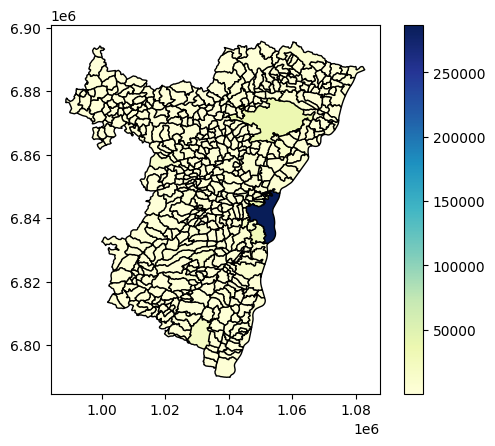

In [108]:
gpd_studied_areas_population.plot("originating_trip", legend=True, cmap='YlGnBu', edgecolor='black')

## 2.2 Trip Attraction

In [112]:
# set index for te ehmployment data of the study area
df_studied_area_employee = df_studied_area_employee.set_index("municipality_id")
df_studied_area_employee.head()

,employment
municipality_id,
67001,401.0
67002,70.0
67003,2.0
67004,157.0
67005,48.0


In [114]:
total_population = df_studied_areas_population['population'].sum()
total_employment = df_studied_area_employee['employment'].sum()
employment = df_studied_area_employee['employment'].values

trips_in_zones = min(0.7 * total_employment, 0.7 * total_population)
arriving_trips = ( employment / (total_employment) ) * trips_in_zones

In [121]:
employment.shape 

(511,)

In [122]:
# df_studied_areas_population['arriving_trips'] = arriving_trips